In [23]:
def solve_optimization(gainF, risk, cost, alpha, Q):
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost

    risk = risk.clip(min=0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")

    utils = cp.multiply(cp.multiply(gainF, risk), d)
    constraints = [d >= 0, cp.sum(cost * d) <= Q]

    if alpha == 'inf':
        t = cp.Variable()
        objective = cp.Maximize(t)
        constraints.append(utils >= t)
    elif alpha == 1:
        objective = cp.Maximize(cp.sum(cp.log(utils)))
    elif alpha == 0:
        objective = cp.Maximize(cp.sum(utils))
    else:
        objective = cp.Maximize(cp.sum(utils**(1-alpha)) / (1-alpha))

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")

    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)

    return optimal_decision, optimal_value



def solve_closed_form(g, r, c, alpha, Q):

    g = g.detach().cpu().numpy() if isinstance(g, torch.Tensor) else g
    r = r.detach().cpu().numpy() if isinstance(r, torch.Tensor) else r
    c = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else c

    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
        
    sol, obj = d_star_closed, AlphaFairness(d_star_closed*g*r, alpha)

    return sol, obj
def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    if alpha == 1:
        S = np.sum(c / (r * g))

    if alpha == 0:
        # Utilitarian case: Allocate everything to the individual with the highest ratio
        ratios = (r * g) / c
        i_star = np.argmax(ratios)
        # Gradient is Q * g_i / c_i at the allocated index, zero elsewhere
        gradient[i_star, i_star] = Q * g[i_star] / c[i_star]
        return gradient

    elif alpha == 'inf':
        # Maximin case
        n = len(c)
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar

        # Compute d_star
        d_star, _ = solve_closed_form(g,r,c, alpha='inf', Q=Q)  # Shape: (n,)

        # Initialize gradient matrix
        gradient = np.zeros((n, n))

        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_i = -d_i*/r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star[i] / r[i] - (d_star[i] * c[i]) / (r[i] * g[i] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient

    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star, _ = solve_closed_form(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient

import torch
def AlphaFairness(util, alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha) / (1-alpha))

In [24]:
import cvxpy as cp
import numpy as np

n = 5
x = cp.Variable(n)

g = np.array([1, 1,1,1,1])
r = np.array([1, 2, 3, 4, 5])
p = cp.Parameter(n, nonneg=True)
a = 2.0
c = np.array([1, 2, 3, 4, 5])
Q = 10

obj = cp.Maximize((1/(1-a))*cp.sum(cp.power(cp.multiply(p,x), 1-a)))
# obj = cp.Maximize(cp.sum(cp.log(cp.multiply(p,x))))
constr = [cp.sum(cp.multiply(c,x)) <= Q, x >= 0]
problem = cp.Problem(obj, constr)

p.value = g * r
print(p.value.shape)
problem.solve(verbose=False)
print(x.value)
print("Is DPP? ", problem.is_dcp(dpp=True))
print("Is DCP? ", problem.is_dcp(dpp=False))

(5,)
[1.99993776 0.99996888 0.66669739 0.49998444 0.40001889]
Is DPP?  True
Is DCP?  True


In [25]:
sols_closed = solve_closed_form(g, r, c, alpha=a, Q=Q)[0]
grad_closed = compute_gradient_closed_form(g, r, c, alpha=a, Q=Q)
solver_sols = solve_optimization(torch.tensor(g), torch.tensor(r), torch.tensor(c), alpha=a, Q=Q)[0]

In [26]:
import torch
from cvxpylayers.torch import CvxpyLayer

# Create a cvxpylayer with the current cvxpy problem.
cvxpylayer = CvxpyLayer(problem, parameters=[p], variables=[x])
assert problem.is_dpp()

# Create a torch tensor for the parameter p.
p_torch = torch.tensor(p.value, dtype=torch.float32, requires_grad=True)

# Solve the problem.
solution, = cvxpylayer(p_torch)

print('solution', solution.requires_grad)

# Use the solution to compute a loss and perform backpropagation.
loss = solution.sum()
gradP = torch.autograd.grad(loss, p_torch, retain_graph=True, create_graph=True)[0]
alpha = 2.0
# risk = risk.detach().to('cpu').numpy()
# gainF = gainF.detach().to('cpu').numpy().flatten()
# cost = cost.detach().to('cpu').numpy().flatten()
g_torch = torch.tensor(g, dtype=torch.float32, requires_grad=True)
r_torch = torch.tensor(r, dtype=torch.float32, requires_grad=True)
sols_torch = torch.tensor(sols_closed, dtype=torch.float32, requires_grad=True)
util = g_torch * r_torch * solution
if alpha == 1:
    pred_obj = torch.sum(torch.log(util))
elif alpha == 0:
    pred_obj =  torch.sum(util)
elif alpha == 'inf':
    pred_obj = torch.min(util)
else:
    pred_obj = torch.sum(util**(1-alpha) / (1-alpha))

normalized_regret = (sols_torch - pred_obj) / (abs(sols_torch) + 1e-7)
print(normalized_regret.requires_grad_(True))

print(pred_obj)
from torch import nn
mseloss = nn.MSELoss()
loss = mseloss(solution, sols_torch)

newgrad = torch.autograd.grad(loss, p_torch, retain_graph=True, create_graph=True)


print("Optimal x:", solution)
print("Gradient of p:", gradP)
print("Gradient of p:", newgrad)

solution True
tensor([1.5708, 2.1416, 2.7125, 3.2833, 3.8541], grad_fn=<DivBackward0>)
tensor(-2.5000, grad_fn=<SumBackward0>)
Optimal x: tensor([2.0001, 1.0000, 0.6667, 0.5000, 0.4000],
       grad_fn=<_CvxpyLayerFnFnBackward>)
Gradient of p: tensor([-0.5434, -0.0217,  0.0411,  0.0517,  0.0513])
Gradient of p: (tensor([ 0.6732, -0.0203, -0.0576, -0.0548, -0.0481]),)


In [27]:
grad_l_d = (r * g) ** (1 - a) * r ** (-a)
finalgrad = grad_l_d @ grad_closed

In [28]:
# analytical gradient, gradient computed by cvxpylayers
-1 * finalgrad, newgrad

(array([ 1.15369307, -0.19059133, -0.10610944, -0.06261704, -0.04074279]),
 (tensor([ 0.6732, -0.0203, -0.0576, -0.0548, -0.0481]),))

In [29]:
import matplotlib.pyplot as plt

def plot_gradients(analytical, numerical, title="Gradient Comparison"):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(analytical, cmap='viridis', interpolation='none')
    plt.title('Analytical Gradient')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(numerical, cmap='viridis', interpolation='none')
    plt.title('CVXPY grad')
    plt.colorbar()
    
    plt.suptitle(title)
    plt.show()

In [ ]:
# Cosine Similarity between the gradients, Finite Different and Closed Form, and Cvxpylayer.

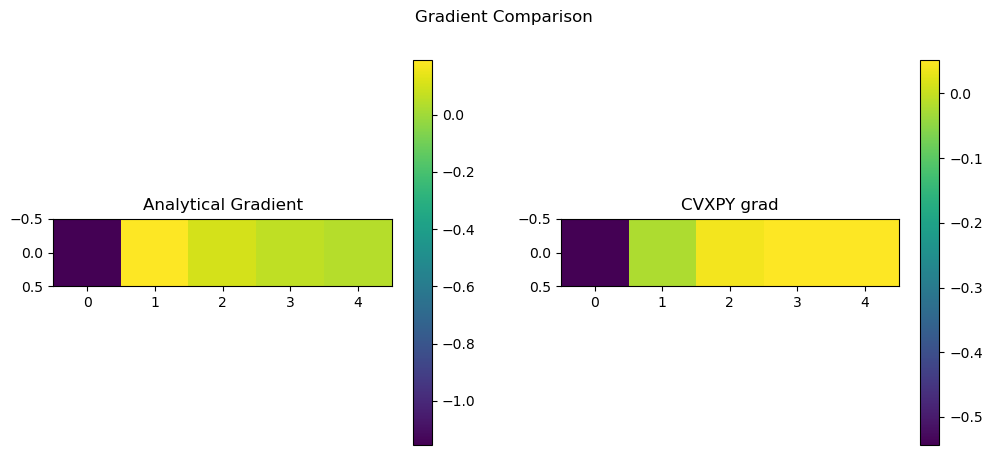

In [30]:
plot_gradients(finalgrad.reshape(1, -1), gradP.detach().cpu().numpy().reshape(1, -1), title="Gradient Comparison")

In [31]:
import torch.nn as nn

class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softplus()  # Ensuring outputs are positive if needed
        )

    def forward(self, x):
        return self.fc(x)

In [32]:
import sys
import warnings
import time
import copy
import json
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import cvxpy as cp

from pyepo.model.opt import optModel
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')
from myutil import *
from features import get_all_features

# Suppress warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [33]:
import pandas as pd
df = pd.read_csv('data/data.csv')
# fix random seed for reproducibility

# report statistics on this dataset
df = df.sample(n=100, random_state=1)

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
#df['risk_score_t'] = df['risk_score_t'].apply(lambda x: 0.1 if x < 0.1 else x)
df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)


risk = df['risk_score_t'].values
risk = risk + 0.001 if 0 in risk else risk


feats = df[get_all_features(df)].values
gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.random.normal(1, 0.5, len(risk)).clip(0.1, 2)
race = df['race'].values

# transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

from sklearn.model_selection import train_test_split


In [34]:
# Train-Test Split
X_train, X_test, risk_train, risk_test, gainF_train, gainF_test, cost_train, cost_test = train_test_split(
    feats, risk, gainF, cost, test_size=0.5, random_state=42
)
# Convert to Torch Tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
risk_train_torch = torch.tensor(risk_train, dtype=torch.float32, requires_grad=True)
risk_test_torch = torch.tensor(risk_test, dtype=torch.float32)
gainF_train_torch = torch.tensor(gainF_train, dtype=torch.float32)
gainF_test_torch = torch.tensor(gainF_test, dtype=torch.float32)
cost_train_torch = torch.tensor(cost_train, dtype=torch.float32)
cost_test_torch = torch.tensor(cost_test, dtype=torch.float32)


# CVXPYLAYER TRAINING

In [35]:
# Define Optimization Problem
n = risk_train_torch.shape[0]
x = cp.Variable(n)  # Allocation variable
p = cp.Parameter(n, nonneg=True)  # Risk * Gain

alpha = 2  # Alpha Fairness Parameter
Q = 20 # Budget Constraint

# Define Alpha-Fairness Objective
if alpha == 1:
    obj = cp.Maximize(cp.sum(cp.log(cp.multiply(p, x))))
elif alpha == 0:
    obj = cp.Maximize(cp.sum(cp.multiply(p, x)))
elif alpha == 'inf':
    obj = cp.Maximize(cp.min(cp.multiply(p, x)))
else:
    obj = cp.Maximize((1 / (1 - alpha)) * cp.sum(cp.power(cp.multiply(p, x), 1 - alpha)))

# Define Constraints
constraints = [cp.sum(cp.multiply(cost_train, x)) <= Q, x >= 0]

# Define Problem
problem = cp.Problem(obj, constraints)
cvxpylayer = CvxpyLayer(problem, parameters=[p], variables=[x])

# Ensure problem is Differentiable
assert problem.is_dpp()

# Neural Network to Predict Risk
class RiskPredictor(nn.Module):
    def __init__(self, input_dim):
        super(RiskPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output is risk between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model, Loss, Optimizer
model = RiskPredictor(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [44]:
def torchAlphaFairness(util, alpha):
    if alpha == 1:
        return torch.sum(torch.log(util))
    elif alpha == 0:
        return torch.sum(util)
    elif alpha == 'inf':
        return torch.min(util)
    else:
        return torch.sum(util**(1-alpha) / (1-alpha))

# Training Loop
regret_log = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Predict Risk
    pred_risk = model(X_train_torch).squeeze()  # Ensure correct shape

    # Compute p = risk * gainF
    p_pred = pred_risk * gainF_train_torch
    p_true = risk_train_torch * gainF_train_torch

    # Compute Optimal Allocations
    x_pred, = cvxpylayer(p_pred)
    x_true, = cvxpylayer(p_true)

    loss = criterion(x_pred, x_true)

    # Backpropagate
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")
    model.eval()
    true_risk = risk_train_torch
    pred_risk = model(X_train_torch).squeeze()
    pred_risk = pred_risk.clip(min=0.001)
    _, opt_val = solve_closed_form(gainF_train_torch, true_risk, cost_train_torch, alpha, Q)
    pred_sol, _ = solve_closed_form(gainF_train_torch, pred_risk, cost_train_torch, alpha, Q)
    pred_sol = torch.tensor(pred_sol, dtype=torch.float32)
    pred_obj = torchAlphaFairness(pred_sol * gainF_train_torch * true_risk, alpha)

    normalized_regret = (opt_val - pred_obj) / (abs(pred_obj) + 1e-7)
    regret_log.append(normalized_regret.detach().cpu().numpy().item())
    model.train()
# Evaluate on Test Set
model.eval()
with torch.no_grad():
    pred_risk_test = model(X_test_torch).squeeze()
    p_pred_test = pred_risk_test * gainF_test_torch
    x_pred_test, = cvxpylayer(p_pred_test)
    x_true_test, = cvxpylayer(risk_test_torch * gainF_test_torch)
    test_loss = criterion(x_pred_test, x_true_test)
    print(f"Test Loss: {test_loss.item()}")

# Print Final Results
# print("\nOptimal Allocations (Test):", x_true_test[:5])
# print("Predicted Allocations (Test):", x_pred_test[:5])
print(regret_log)

Epoch 0/100, Loss: 24.240638732910156
Epoch 10/100, Loss: 23.98489761352539
Epoch 20/100, Loss: 24.311628341674805
Epoch 30/100, Loss: 24.24203872680664
Epoch 40/100, Loss: 24.15283966064453
Epoch 50/100, Loss: 23.998319625854492
Epoch 60/100, Loss: 24.0955753326416
Epoch 70/100, Loss: 24.11078453063965
Epoch 80/100, Loss: 23.979267120361328
Epoch 90/100, Loss: 24.249563217163086
Test Loss: 0.0610792450606823
[0.7944861054420471, 0.7981324791908264, 0.7954494953155518, 0.797268271446228, 0.7960355877876282, 0.7965153455734253, 0.7970244884490967, 0.7951962351799011, 0.7995090484619141, 0.7919896841049194, 0.8035805225372314, 0.7888797521591187, 0.8074352741241455, 0.7896032929420471, 0.8022027611732483, 0.7934722304344177, 0.7976305484771729, 0.7973552346229553, 0.7938007712364197, 0.8017764091491699, 0.7902767658233643, 0.8061025738716125, 0.7893657088279724, 0.8046877980232239, 0.7914577722549438, 0.8012354373931885, 0.7935193777084351, 0.7995258569717407, 0.7941857576370239, 0.79970

In [37]:
pred_sol = solve_closed_form(gainF_test_torch, pred_risk, cost_test_torch, alpha, Q)[0]

In [38]:
x_true_test, x_pred_test

(tensor([0.3405, 0.6291, 0.9194, 0.2224, 0.2725, 0.5867, 0.4208, 1.0822, 0.3707,
         0.2065, 0.4033, 0.5177, 0.3342, 0.6247, 0.0881, 0.6601, 0.1414, 0.5490,
         0.3418, 0.2708, 0.2482, 0.6931, 1.1049, 0.4066, 0.5687, 0.8798, 0.3217,
         0.4161, 0.1150, 0.5313, 0.1131, 0.1206, 0.6517, 0.0895, 0.8409, 0.6741,
         0.5132, 0.3817, 0.6936, 0.6957, 0.1032, 1.0577, 0.7020, 0.2104, 0.1393,
         0.0723, 0.1643, 0.5401, 0.1187, 0.1952]),
 tensor([0.2220, 0.4450, 0.6304, 0.1227, 0.1474, 0.4600, 0.2838, 0.7129, 0.1510,
         0.1076, 0.2610, 0.3277, 0.1621, 1.3838, 0.0346, 0.5423, 0.0745, 0.4580,
         0.4135, 0.0801, 0.0992, 0.6467, 1.0137, 0.4031, 0.5407, 1.3179, 0.1391,
         1.4475, 0.0486, 0.9883, 0.0431, 0.0257, 0.5484, 0.0131, 0.8758, 0.6430,
         0.4671, 0.3665, 0.3492, 0.4979, 0.0340, 0.6854, 0.8658, 0.1276, 0.0414,
         0.0132, 0.1109, 0.4256, 0.0413, 0.1183]))

In [39]:
util = gainF_test_torch * risk_test_torch * x_true_test
util_pred = gainF_test_torch * risk_test_torch * x_pred_test

In [40]:


true_obj = torchAlphaFairness(util, alpha)
pred_obj = torchAlphaFairness(util_pred, alpha)

In [41]:
true_obj, pred_obj

(tensor(-11.1661), tensor(-14.7127))